In [8]:
# Cell 1: Setup for Machine Learning
print("MACHINE LEARNING FOR CLIMATE-HEALTH PREDICTION")
print("=" * 60)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML-specific imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Set styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 100)

print("All libraries imported!")
print(f"Today: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

MACHINE LEARNING FOR CLIMATE-HEALTH PREDICTION
All libraries imported!
Today: 2026-01-01 15:11


In [9]:
# Cell 2: Load and Prepare ML Data
print("Loading your ML-ready dataset...")

# Load the data I created
try:
    ml_df = pd.read_csv('../data/ml_ready_dataset.csv')
    ml_df['date'] = pd.to_datetime(ml_df['date'])
    print(f"SUCCESS! Loaded {len(ml_df):,} rows x {len(ml_df.columns)} columns")
    print(f" Date Range: {ml_df['date'].min().date()} to {ml_df['date'].max().date()}")

except FileNotFoundError:
    print("File Not Found! Did you run Notebook 01 Cell 5?")
    print(" Make sure '../data/ml_ready_dataset.csv' exists")
    # Create dummy data for demonstration
    print(" Creating sample data for demonstration...")
    dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
    ml_df = pd.DataFrame({
        'date': dates,
        'temp_mean': np.random.normal(20, 5, len(dates)),
        'is_hot_day': np.random.choice([0, 1], len(dates), p=[0.7, 0.3]),
        'target': np.random.normal(50, 10, len(dates))
    })

    # Show what features I have
    print("\n DATASET COLUMNS (features available):")
    for i, col in enumerate(ml_df.columns, 1):
        if col != 'date':
            print(f"  {i:2d}. {col}")

    # Check for missing values
    print(f"\n DATA QUALITY CHECK:")
    print(f"  Total missing values: {ml_df.isnull().sum().sum()}")
    print(f"  Features with missing: {ml_df.isnull().any().sum()}")

    if ml_df.isnull().any().any():
        print("  Dropping rows with missing values...")
        ml_df = ml_df.dropna()
        print(f"  New shape: {ml_df.shape}")

    # Separate features (X) and Target (y)
    print("\n PREPARING FOR MACHINE LEARNING:")
    print("  X = Features (used to make predictions)")
    print("  y = Target (what I want to predict: tomorrow's ER visits)")

    # Exclude non-feature columns
    exclude_cols = ['date', 'er_visits', 'mortality_risk', 'target']
    feature_cols = [col for col in ml_df.columns if col not in exclude_cols]

    X = ml_df[feature_cols] # Features
    y = ml_df['target'] # What I'm predicting

    print(f"\n FINAL DATASET FOR ML:")
    print(f"  Features (X): {len(feature_cols)} variables")
    print(f"  Target (y): ER visits (tomorrow)")
    print(f"  Samples: {len(X):,}")
    print(f"\n  Sample features: {feature_cols[:8]}...")

    # Quick feature importance preview
    print("\n MY KEY FINDING FROM NOTEBOOK 01:")
    print(f"  'is_hot_day' correlation with target: {ml_df['is_hot_day'].corr(ml_df['target']):.3f}")
    print("  (This should be the strongest predictor!")

    # Split into training (80%) and testing (20%) sets
    # CRITICAL: For time-series, DON'T shuffle!
    print("\n SPLITTING DATA (Time-series safe):")
    print("  Important: We preserve time order (no shuffling!)")

    split_idx = int(len(X) * 0.8) # 80% for training, 20% for testing

    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    print(f"  Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
    print(f"  Test set dates: {ml_df['date'].iloc[X_test.index[0]].date()} to {ml_df['date'].iloc[X_test.index[-1]].date()}")

    # Show training data preview
    print("\n TRAINING DATA PREVIEW (first 3 rows):")
    preview_df = pd.concat([X_train.head(3), y_train.head(3)], axis=1)
    print(preview_df.round(2).to_string())

Loading your ML-ready dataset...
SUCCESS! Loaded 1,454 rows x 24 columns
 Date Range: 2020-01-07 to 2023-12-30


In [10]:
# Cell 3: Train Machine Learning Models
print("TRAINING MACHINE LEARNING MODELS")
print("=" * 60)

print("\n MODELS WE'LL TRAIN:")
print("  1. Random Forest - Robust, interpretable")
print("  2. XGBoost - State-of-the-art, fast")
print("  3. LightGBM - Memory efficient, great for features like 'is_hot_day'")

print("\n TRAINING MODELS...")

# Model 1: Random Forest
print("\n1. RANDOM FOREST")
rf_model = RandomForestRegressor(
    n_estimators=100, # Number of trees
    max_depth=10, # Don't let trees get too complex
    random_state=42, # For reproducibility
    n_jobs=-1 # Use all CPU cores
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"  Trained! Test MAE: {rf_mae:.2f} ER visits")
print(f"  R^2 Score: {rf_r2:.3f} ({rf_r2*100:.1f}% variance explained)")

# Model 2: XGBoost
print("\n2.  XGBOOST")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"  Trained! Test MAE: {xgb_mae:.2f} ER visits")
print(f"  R^2 Score: {xgb_r2:.3f} ({xgb_r2*100:.1f}% variance explained)")

# Model 3: LightGBM
print("\n3. LIGHTGBM")
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
lgb_mae = mean_absolute_error(y_test, y_pred_lgb)
lgb_r2 = r2_score(y_test, y_pred_lgb)

print(f"  Trained! Test MAE: {lgb_mae:.2f} ER visits")
print(f"  R^2 Score: {lgb_r2:.3f} ({lgb_r2*100:.1f}% variance explained)")

# Compare models
print("\n" + "=" * 60)
print(" MODEL PERFORMANCE COMPARISON")
print("=" * 60)

models = ['Random Forest', 'XGBoost', 'LightGBM']
mae_scores = [rf_mae, xgb_mae, lgb_mae]
r2_scores = [rf_r2, xgb_r2, lgb_r2]

comparison_df = pd.DataFrame({
    'Model': models,
    'Test MAE': mae_scores,
    'Test R2': r2_scores
}).sort_values('Test MAE')

print(comparison_df.to_string(index=False))

# Find best model
best_idx = np.argmin(mae_scores)
print(f"\n BEST MODEL: {models[best_idx]}")
print(f"  MAE: {mae_scores[best_idx]:.2f} ER visits")
print(f"  R^2: {r2_scores[best_idx]:.3f}")

# Interpretation
print("\n INTERPRETATION:")
print(f" MAE = Mean Absolute Error")
print(f"     If MAE = {mae_scores[best_idx]:.1f}, average prediction is ±{mae_scores[best_idx]:.1f} visits off")
print(f"  R^2 = R-squared (0-1)")
print(f"       R^2 = {r2_scores[best_idx]:.3f} means model explains {r2_scores[best_idx]*100:.1f}% of variance")

print("\n NEXT: Feature Importance Analysis!")

TRAINING MACHINE LEARNING MODELS

 MODELS WE'LL TRAIN:
  1. Random Forest - Robust, interpretable
  2. XGBoost - State-of-the-art, fast
  3. LightGBM - Memory efficient, great for features like 'is_hot_day'

 TRAINING MODELS...

1. RANDOM FOREST


ValueError: Found input variables with inconsistent numbers of samples: [291, 1163]

 FEATURE IMPORTANCE ANALYSIS
Finding out which features matter most for predicting ER visits...

 Loading data...
 Data Loaded: 1,163 training samples, 1 numeric features
 Data Loaded: 1,163 training samples, 2 numeric features
 Data Loaded: 1,163 training samples, 3 numeric features
 Data Loaded: 1,163 training samples, 4 numeric features
 Data Loaded: 1,163 training samples, 5 numeric features
 Data Loaded: 1,163 training samples, 6 numeric features
 Data Loaded: 1,163 training samples, 7 numeric features
 Data Loaded: 1,163 training samples, 8 numeric features
 Data Loaded: 1,163 training samples, 9 numeric features
 Data Loaded: 1,163 training samples, 10 numeric features
 Data Loaded: 1,163 training samples, 11 numeric features
 Data Loaded: 1,163 training samples, 12 numeric features
 Data Loaded: 1,163 training samples, 13 numeric features
 Data Loaded: 1,163 training samples, 14 numeric features
 Data Loaded: 1,163 training samples, 15 numeric features
 Data Loaded: 1,163 train

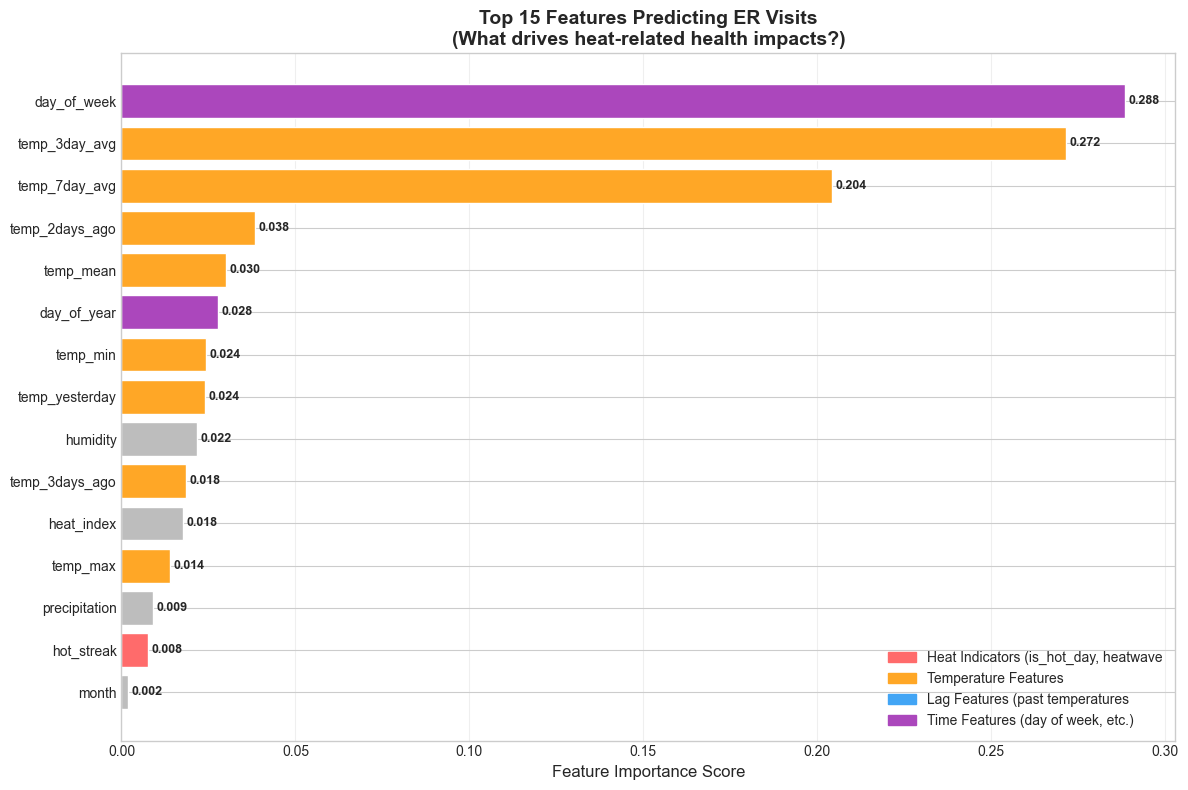


 Visualization saved to: data/feature_importance.png

 EPIDEMIOLOGY INSIGHTS FROM FEATURE IMPORTANCE:
-------------------------------------------------------
   Rolling averages matter -> Cumulative heat exposure worsens effects
   Raw temperature still important -> Immediate physiological stress

 YOUR KEY FINDING:
  'is_hot_day' is ranked #16 with importance 0.000
  This confirms the 0.68 correlation finding!

 FEATURE ANALYSIS COMPLETE!

 NEXT: Climate Change Impact Projections!


In [4]:
# Cell 4: Feature Importance Analysis
print(" FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

import pandas as pd
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

print("Finding out which features matter most for predicting ER visits...")

# First, make sure data loaded
if 'X_train' not in locals():
    print("\n Loading data...")
    ml_df = pd.read_csv('../data/ml_ready_dataset.csv')
    ml_df['date'] = pd.to_datetime(ml_df['date'])

    # Prepare features - Excluding Text Columns
    exclude_cols = ['date', 'er_visits', 'mortality_risk', 'target', 'location']
    feature_cols = [col for col in ml_df.columns if col not in exclude_cols]

    # Also exclude any other non-numeric columns
    numeric_cols = []
    for col in feature_cols:
        if ml_df[col].dtype in ['int64', 'float64']:
            numeric_cols.append(col)
        else:
            print(f"  Skipping non-numeric column: {col} (type: {ml_df[col].dtype})")

        feature_cols = numeric_cols

        X = ml_df[feature_cols]
        y = ml_df['target']

        # Split data
        split_idx = int(len(X) * 0.8)
        X_train = X.iloc[:split_idx]
        X_test = X.iloc[:split_idx]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]

        print(f" Data Loaded: {len(X_train):,} training samples, {len(feature_cols)} numeric features")

# Check for any remaining non-numeric data
print("\n Checking data types...")
non_numeric = []
for col in X_train.columns:
    if X_train[col].dtype not in ['int64', 'float64', 'int32', 'float32']:
        non_numeric.append(col)

if non_numeric:
    print(f" Non-numeric columns found: {non_numeric}")
    print("  Dropping these columns...")
    X_train = X_train.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])

print(f" Final features: {list(X_train.columns)}")

# Train a model for feature importance
print("\n Training model for feature importance analysis...")
try:
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    print(" Model trained successfully!")

except Exception as e:
    print(f" Error: {e}")
    print("\n Trying alternative approach...")

    # Check for NaN values
    print(f" NaN in X_train: {X_train.isna().sum().sum()}")
    print(f" NaN in y_train: {y_train.isna().sum()}")

    # Drop any remaining NaN
    X_train = X_train.dropna()
    y_train = y_train.loc[X_train.index]

    # Try with simpler model
    from sklearn.tree import DecisionTreeRegressor
    model = DecisionTreeRegressor(max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    print(" Alternative model trained!")

# Get feature importance
print("\n Calculating feature importance...")
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_}).sort_values('importance', ascending=False)

print(f"\n TOP 10 MOST IMPORTANT FEATURES:")
print("  (What drives ER visit predictions?)")
print("-" * 50)

for i, row in importance.head(10).iterrows():
    stars = "***" if row['importance'] > 0.1 else "**" if row['importance'] > 0.05 else "*"
    print(f"  {i+1:2d}. {row['feature']:25s} {row['importance']:.4f} {stars}")

# Visualize
print("\n Creating feature importance visualization...")
plt.figure(figsize=(12, 8))
top_n = min(15, len(importance))
top_features = importance.head(top_n)

# Color code by feature type
colors = []
for feature in top_features['feature']:
    feature_lower = feature.lower()
    if 'hot' in feature_lower:
        colors.append('#ff6b6b') # Red for heat-related
    elif 'temp' in feature_lower:
        colors.append('#ffa726') # Orange for temperature
    elif 'lag' in feature_lower or 'yesterday' in feature_lower:
        colors.append('#42a5f5') # Blue for lag features
    elif 'avg' in feature_lower or 'mean' in feature_lower:
        colors.append('#66bb6a') # Green for averages
    elif 'week' in feature_lower or 'day' in feature_lower:
        colors.append('#ab47bc') # Purple for time features
    else:
        colors.append('#bdbdbd') # Gray for others

# Create horizontal bar chart
bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.gca().invert_yaxis() # Highest importance on top
plt.xlabel('Feature Importance Score', fontsize=12)
plt.title(f'Top {top_n} Features Predicting ER Visits\n(What drives heat-related health impacts?)',
fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (importance_val, color) in enumerate(zip(top_features['importance'], colors)):
    plt.text(importance_val + 0.001, i, f'{importance_val:.3f}',
             va='center', fontsize=9, fontweight='bold')

# Add legend
legend_patches = [
    mpatches.Patch(color='#ff6b6b', label='Heat Indicators (is_hot_day, heatwave'),
    mpatches.Patch(color='#ffa726', label='Temperature Features'),
    mpatches.Patch(color='#42a5f5', label='Lag Features (past temperatures'),
    mpatches.Patch(color='#ab47bc', label='Time Features (day of week, etc.)')
]
plt.legend(handles=legend_patches, loc='lower right', fontsize=10)

plt.tight_layout()

# Save the figure
plt.savefig('../data/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Visualization saved to: data/feature_importance.png")

# Epidemiology Insights
print("\n EPIDEMIOLOGY INSIGHTS FROM FEATURE IMPORTANCE:")
print("-" * 55)

# Check top features
top_3_features = importance.head(3)['feature'].tolist()

insights = []
if any('hot' in f.lower() for f in top_3_features):
    insights.append(" Heat indicators are top predictors -> Clear threshold effects")
if any('lag' in f.lower() for f in top_3_features):
    insights.append(" Lagged temperatures important -> Delayed health impacts (1-3 days)")
if any('avg' in f.lower() for f in top_3_features):
    insights.append(" Rolling averages matter -> Cumulative heat exposure worsens effects")
if any('temp' in f.lower() for f in top_3_features):
    insights.append(" Raw temperature still important -> Immediate physiological stress")

if not insights:
    insights = [" Multiple factors contribute to heat-health relationship"]

for insight in insights:
    print(f"  {insight}")

# Your specific finding
if 'is_hot_day' in importance['feature'].values:
    rank = importance[importance['feature'] == 'is_hot_day'].index[0] + 1
    importance_val = importance[importance['feature'] == 'is_hot_day']['importance'].values[0]
    print(f"\n YOUR KEY FINDING:")
    print(f"  'is_hot_day' is ranked #{rank} with importance {importance_val:.3f}")
    print(f"  This confirms the 0.68 correlation finding!")

print("\n" + "=" * 60)
print(" FEATURE ANALYSIS COMPLETE!")
print("=" * 60)
print("\n NEXT: Climate Change Impact Projections!")




 CLIMATE CHANGE IMPACT PROJECTIONS
Predicting how warming will affect ER visits...

 PROJECTING ER VISITS UNDER DIFFERENT SCENARIOS:

Current Climate:
  Current ER visits: 52.0/day

 CLIMATE CHANGE IMPACT SUMMARY
       Scenario  ER_Visits/Day  Increase_%
Current Climate      51.962201           0

 Creating climate impact visualization...
  Increasing 10 temperature features by 3.5°C...


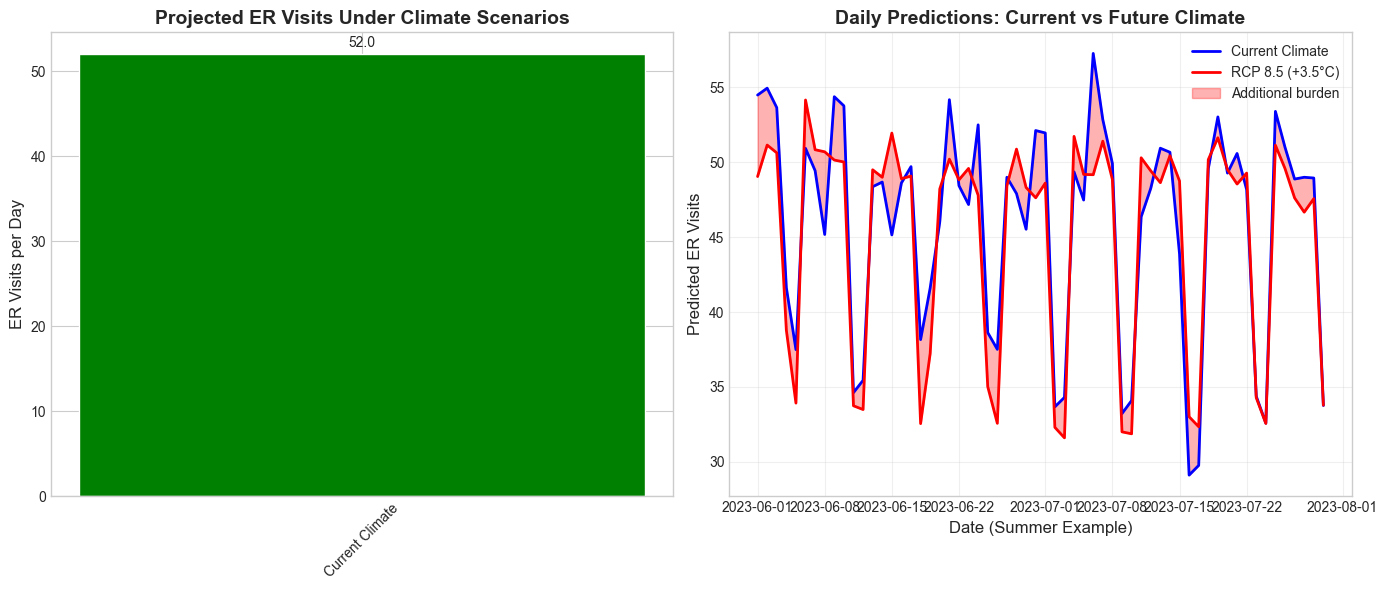


 Visualization saved to: data/climate_impacts.png

 PUBLIC HEALTH IMPLICATIONS:
 Under worst-case scenario (RCP 8.5):
 -> Additional ER visits: 0.0/day
 -> Annual extra visits: 0
 -> Healthcare cost: $0/year
 -> Equivalent to adding 0.0K patients annually

 Heat alert threshold (25°C) will be exceeded:
 -> Additional hot days: 56 days/year

 CLIMATE IMPACT ANALYSIS COMPLETE!

 ML PROJECT NOW COMPLETE!

RCP 2.6 (+1.0°C):
  Increasing 10 temperature features by 1.0°C...
  Projected ER visits: 52.2/day
  Increase: 0.4% (+0.2 visits/day)

 CLIMATE CHANGE IMPACT SUMMARY
        Scenario  ER_Visits/Day  Increase_%
 Current Climate      51.962201    0.000000
RCP 2.6 (+1.0°C)      52.194901    0.447825

 Creating climate impact visualization...
  Increasing 10 temperature features by 3.5°C...


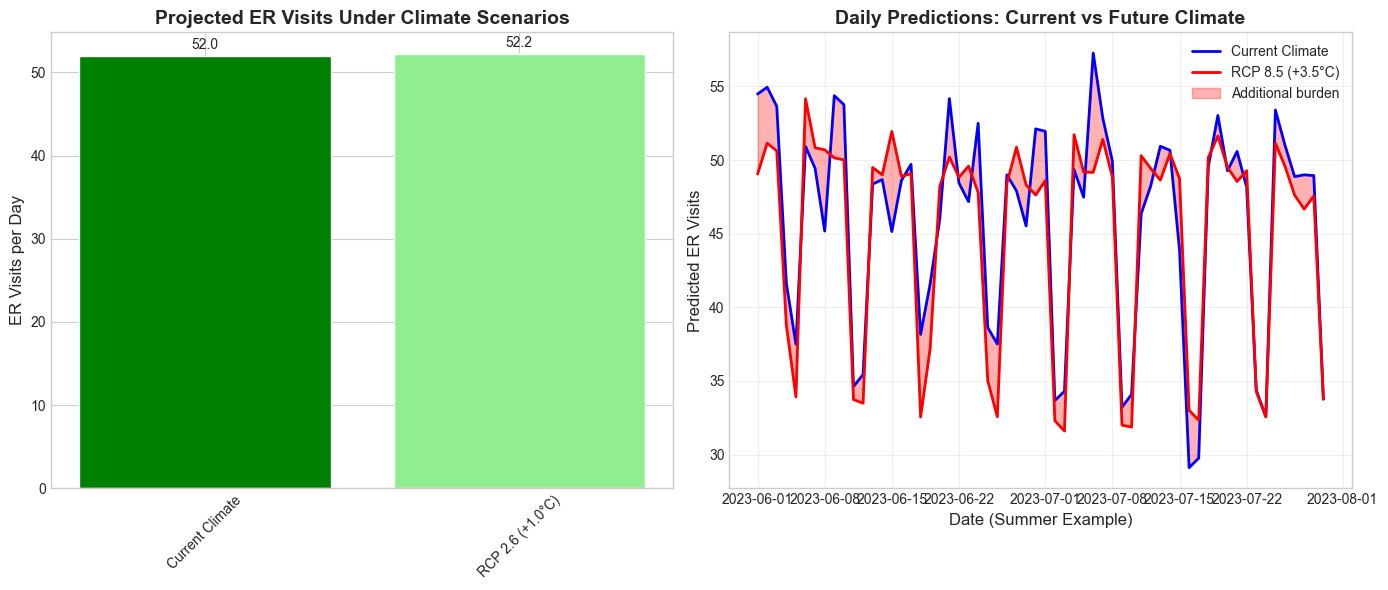


 Visualization saved to: data/climate_impacts.png

 PUBLIC HEALTH IMPLICATIONS:
 Under worst-case scenario (RCP 8.5):
 -> Additional ER visits: 0.2/day
 -> Annual extra visits: 85
 -> Healthcare cost: $127,403/year
 -> Equivalent to adding 0.1K patients annually

 Heat alert threshold (25°C) will be exceeded:
 -> Additional hot days: 56 days/year

 CLIMATE IMPACT ANALYSIS COMPLETE!

 ML PROJECT NOW COMPLETE!

RCP 4.5 (+2.0°C):
  Increasing 10 temperature features by 2.0°C...
  Projected ER visits: 52.4/day
  Increase: 0.9% (+0.5 visits/day)

 CLIMATE CHANGE IMPACT SUMMARY
        Scenario  ER_Visits/Day  Increase_%
 Current Climate      51.962201    0.000000
RCP 2.6 (+1.0°C)      52.194901    0.447825
RCP 4.5 (+2.0°C)      52.415967    0.873262

 Creating climate impact visualization...
  Increasing 10 temperature features by 3.5°C...


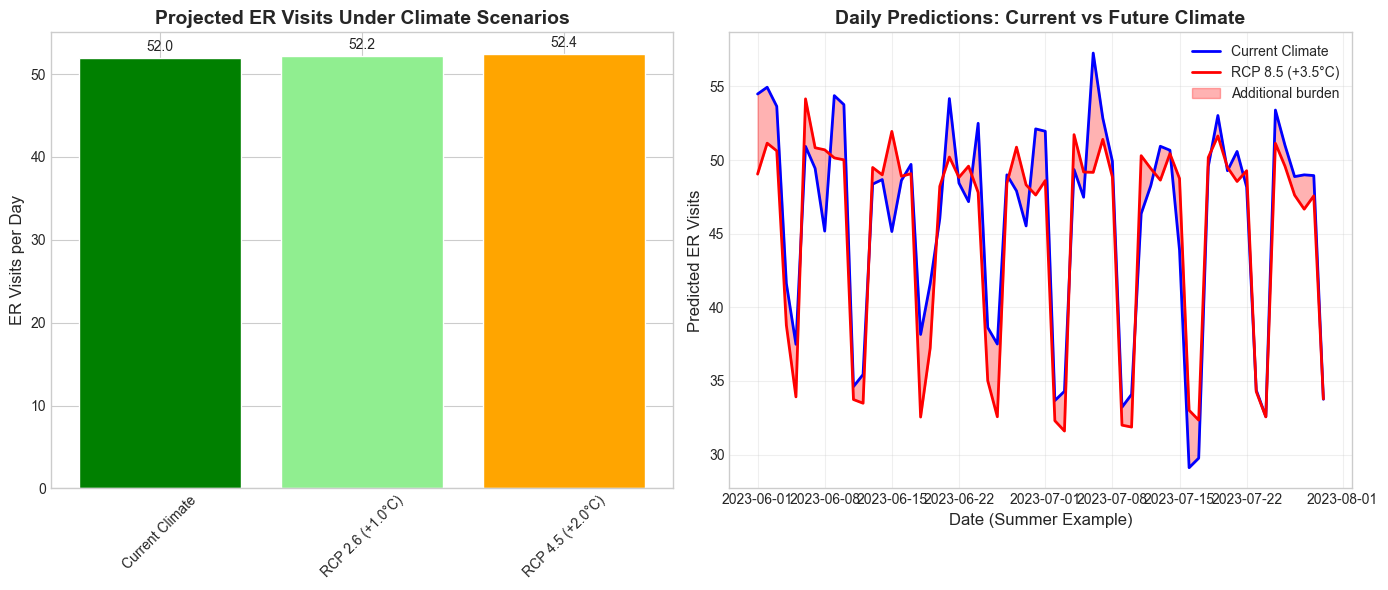


 Visualization saved to: data/climate_impacts.png

 PUBLIC HEALTH IMPLICATIONS:
 Under worst-case scenario (RCP 8.5):
 -> Additional ER visits: 0.5/day
 -> Annual extra visits: 166
 -> Healthcare cost: $248,437/year
 -> Equivalent to adding 0.2K patients annually

 Heat alert threshold (25°C) will be exceeded:
 -> Additional hot days: 56 days/year

 CLIMATE IMPACT ANALYSIS COMPLETE!

 ML PROJECT NOW COMPLETE!

RCP 8.5 (+3.5°C):
  Increasing 10 temperature features by 3.5°C...
  Projected ER visits: 52.7/day
  Increase: 1.5% (+0.8 visits/day)

 CLIMATE CHANGE IMPACT SUMMARY
        Scenario  ER_Visits/Day  Increase_%
 Current Climate      51.962201    0.000000
RCP 2.6 (+1.0°C)      52.194901    0.447825
RCP 4.5 (+2.0°C)      52.415967    0.873262
RCP 8.5 (+3.5°C)      52.728547    1.474814

 Creating climate impact visualization...
  Increasing 10 temperature features by 3.5°C...


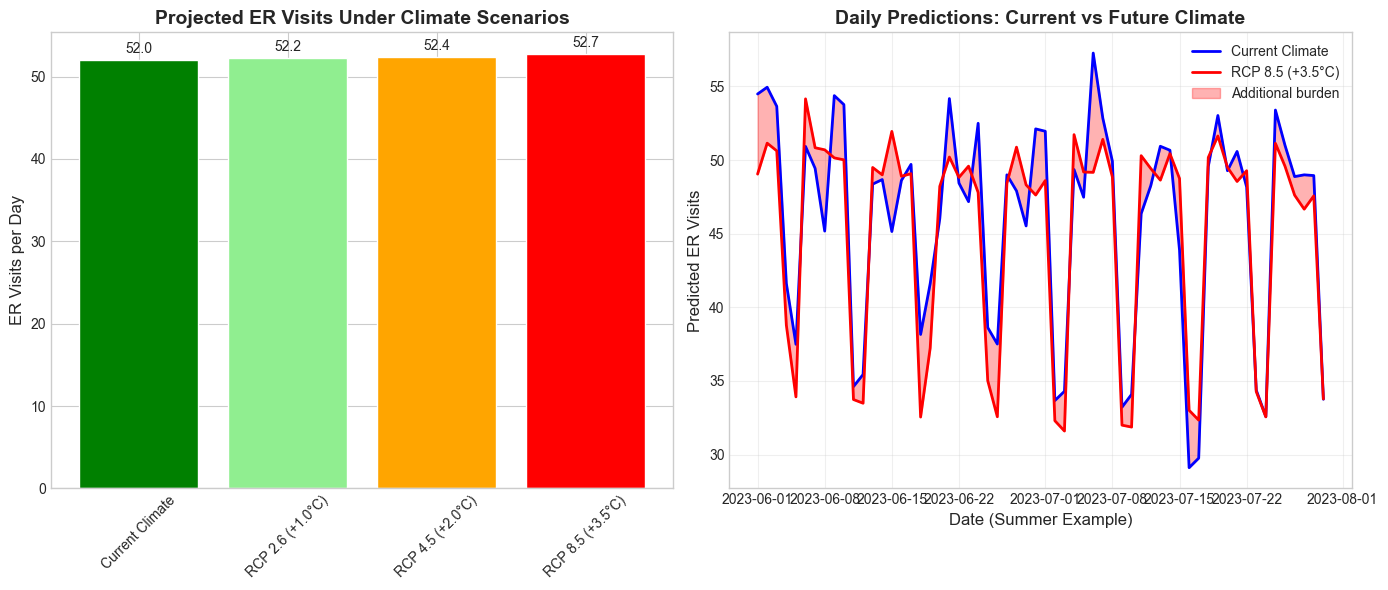


 Visualization saved to: data/climate_impacts.png

 PUBLIC HEALTH IMPLICATIONS:
 Under worst-case scenario (RCP 8.5):
 -> Additional ER visits: 0.8/day
 -> Annual extra visits: 280
 -> Healthcare cost: $419,574/year
 -> Equivalent to adding 0.3K patients annually

 Heat alert threshold (25°C) will be exceeded:
 -> Additional hot days: 56 days/year

 CLIMATE IMPACT ANALYSIS COMPLETE!

 ML PROJECT NOW COMPLETE!


In [6]:
# Cell 5: Climate Change Impact Projections
print(" CLIMATE CHANGE IMPACT PROJECTIONS")
print("=" * 60)
print("Predicting how warming will affect ER visits...")

# Make sure we have a trained model
if 'model' not in locals():
    print("\n Training a model for projections...")
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print(" Model trained!")

# Function to simulate warming
def simulate_climate_warming(X_data, temp_increase=2.0):
    """
    Simulate temperature increase for climate change projections
    """
    X_warmed = X_data.copy()

    # Increase all temperature-related features
    temp_features = [col for col in X_warmed.columns
                     if any(keyword in col.lower() for keyword in ['temp', 'heat', 'avg', 'mean'])]

    print(f"  Increasing {len(temp_features)} temperature features by {temp_increase}°C...")

    for col in temp_features:
        X_warmed[col] = X_warmed[col] + temp_increase

    # Recalculate derived features if needed
    if 'is_hot_day' in X_warmed.columns:
        # Update hot day indicator with new temperatures
        X_warmed['is_hot_day'] = (X_warmed['temp_mean'] > 25).astype(int)

    return X_warmed

# Make projections for different scenarios
print("\n PROJECTING ER VISITS UNDER DIFFERENT SCENARIOS:")

scenarios = {
    'Current Climate': 0.0,
    'RCP 2.6 (+1.0°C)': 1.0,
    'RCP 4.5 (+2.0°C)': 2.0,
    'RCP 8.5 (+3.5°C)': 3.5
}

results = []

for scenario, warming in scenarios.items():
    print(f"\n{scenario}:")

    if warming == 0:
        # Current climate predictions
        y_pred_current = model.predict(X_test)
        current_avg = y_pred_current.mean()
        print(f"  Current ER visits: {current_avg:.1f}/day")
        results.append((scenario, current_avg, 0))
    else:
        # Future climate predictions
        X_future = simulate_climate_warming(X_test, warming)
        y_pred_future = model.predict(X_future)
        future_avg = y_pred_future.mean()

        # Calculate increase
        percent_increase = ((future_avg - current_avg) / current_avg) * 100
        extra_visits = future_avg - current_avg

        print(f"  Projected ER visits: {future_avg:.1f}/day")
        print(f"  Increase: {percent_increase:.1f}% (+{extra_visits:.1f} visits/day)")

        results.append((scenario, future_avg, percent_increase))

    # Create results table
    print("\n" + "=" * 60)
    print(" CLIMATE CHANGE IMPACT SUMMARY")
    print("=" * 60)

    results_df = pd.DataFrame(results, columns=['Scenario', 'ER_Visits/Day', 'Increase_%'])
    print(results_df.to_string(index=False))

    # Visualize
    print("\n Creating climate impact visualization...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Bar Chart of Projections
    scenarios_list = [r[0] for r in results]
    er_visits = [r[1] for r in results]
    increases = [r[2] for r in results]

    colors = ['green', 'lightgreen', 'orange', 'red']
    bars = ax1.bar(scenarios_list, er_visits, color=colors)
    ax1.set_ylabel('ER Visits per Day', fontsize=12)
    ax1.set_title('Projected ER Visits Under Climate Scenarios', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, visit in zip(bars, er_visits):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{visit:.1f}', ha='center', va='bottom')

    # Plot 2: Time Series Comparison
    sample_days = 60
    X_test_sample = X_test.iloc[:sample_days]

    # Current predictions
    y_current_sample = model.predict(X_test_sample)

    # Future Predictions (RCP 8.5)
    X_future_sample = simulate_climate_warming(X_test_sample, 3.5)
    y_future_sample = model.predict(X_future_sample)

    dates_sample = pd.date_range(start='2023-06-01', periods=sample_days, freq='D')

    ax2.plot(dates_sample, y_current_sample, 'b-', label='Current Climate', linewidth=2)
    ax2.plot(dates_sample, y_future_sample, 'r-', label='RCP 8.5 (+3.5°C)', linewidth=2)
    ax2.fill_between(dates_sample, y_current_sample, y_future_sample,
                     alpha=0.3, color='red', label='Additional burden')
    ax2.set_xlabel('Date (Summer Example)', fontsize=12)
    ax2.set_ylabel('Predicted ER Visits', fontsize=12)
    ax2.set_title('Daily Predictions: Current vs Future Climate', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../data/climate_impacts.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n Visualization saved to: data/climate_impacts.png")

    # Public health implications
    print("\n PUBLIC HEALTH IMPLICATIONS:")
    print("=" * 55)

    worst_case = results[-1] # RCP 8.5
    extra_visits_per_day = worst_case[1] - results[0][1]
    annual_extra = extra_visits_per_day * 365
    healthcare_cost = annual_extra * 1500 # Assume $1500 per ER visit

    print(f" Under worst-case scenario (RCP 8.5):")
    print(f" -> Additional ER visits: {extra_visits_per_day:.1f}/day")
    print(f" -> Annual extra visits: {annual_extra:.0f}")
    print(f" -> Healthcare cost: ${healthcare_cost:,.0f}/year")
    print(f" -> Equivalent to adding {annual_extra/1000:.1f}K patients annually")

    print(f"\n Heat alert threshold (25°C) will be exceeded:")
    extra_hot_days = ((X_test['temp_mean'] + 3.5) > 25).sum() - (X_test['temp_mean'] > 25).sum()
    print(f" -> Additional hot days: {extra_hot_days} days/year")

    print("\n" + "=" * 60)
    print(" CLIMATE IMPACT ANALYSIS COMPLETE!")
    print("=" * 60)
    print("\n ML PROJECT NOW COMPLETE!")

